In [1]:
%load_ext lab_black

In [2]:
import math
from typing import Union

import torch as th
import torch.nn.functional as F
import triton
import triton.language as tl
from kitsu.utils.utils import cummul
from torch import Tensor, nn
from torch.nn.parameter import Parameter

from fast_gem.functional import triton_utils as tu

In [3]:
!gpustat

29f6a71229ef         Tue Jul  2 11:04:13 2024  535.154.05
[0] NVIDIA RTX A5000 | 22°C,   0 % |  1551 / 24564 MB |
[1] NVIDIA RTX A5000 | 52°C, 100 % | 15901 / 24564 MB |
[2] NVIDIA RTX A5000 | 23°C,   0 % |     3 / 24564 MB |
[3] NVIDIA RTX A5000 | 23°C,   0 % |     3 / 24564 MB |
[4] NVIDIA RTX A5000 | 24°C,   0 % |     3 / 24564 MB |
[5] NVIDIA RTX A5000 | 25°C,   0 % |     3 / 24564 MB |
[6] NVIDIA RTX A5000 | 25°C,   0 % |     3 / 24564 MB |
[7] NVIDIA RTX A5000 | 23°C,   0 % |     3 / 24564 MB |
[8] NVIDIA RTX A5000 | 25°C,   0 % |     3 / 24564 MB |
[9] NVIDIA RTX A5000 | 26°C,   0 % |     3 / 24564 MB |


In [4]:
th.cuda.set_device(6)

In [17]:
def gem_torch_1d(x: Tensor, p: Union[float, Tensor] = 3.0, eps=1e-6, keepdim=True):
    assert x.ndim == 3, f"Unknown `x` shape: {x.shape}"
    x = x.clamp_min(eps).pow_(p).mean(-1, keepdim=keepdim).pow_(1.0 / p)
    return x

In [6]:
@triton.autotune(
    configs=[
        triton.Config({"BLK_L": 4096}),
        triton.Config({"BLK_L": 2048}),
        triton.Config({"BLK_L": 1024}),
        triton.Config({"BLK_L": 512}),
        triton.Config({"BLK_L": 256}),
        triton.Config({"BLK_L": 128}),
        triton.Config({"BLK_L": 64}),
        triton.Config({"BLK_L": 32}),
    ],
    key=["str_x_L", "str_y_C", "L"],
)
@triton.jit
def gem_forward_1d_kernel(
    x_ptr,
    y_ptr,
    p,
    eps,
    str_x_B,
    str_x_C,
    str_x_L,
    str_y_B,
    str_y_C,
    L,
    IS_P_TENSOR: tl.constexpr,
    BLK_L: tl.constexpr,
):
    pid_b = tl.program_id(0)
    pid_c = tl.program_id(1)
    offs_l = tl.arange(0, BLK_L)  # l
    x_ptrs = x_ptr + pid_b * str_x_B + pid_c * str_x_C + offs_l * str_x_L

    if IS_P_TENSOR:
        p = tl.load(p)

    y = 0.0
    for idx_n in range(tl.cdiv(L, BLK_L)):
        mask = offs_l < L - idx_n * BLK_L
        x = tl.load(x_ptrs, mask=mask, other=0.0)  # l

        # calculate adaptive average pooling
        x = tl.where((x < eps) & mask, eps, x)
        x = tu.pow(x, p)  # l
        y += tl.sum(x)  # 1

        x_ptrs += BLK_L * str_x_L

    y /= L
    y = tu.pow(y, 1 / p)

    y_ptrs = y_ptr + pid_b * str_y_B + pid_c * str_y_C
    tl.store(y_ptrs, y)

In [7]:
@triton.autotune(
    configs=[
        triton.Config({"BLK_L": 4096}),
        triton.Config({"BLK_L": 2048}),
        triton.Config({"BLK_L": 1024}),
        triton.Config({"BLK_L": 512}),
        triton.Config({"BLK_L": 256}),
        triton.Config({"BLK_L": 128}),
        triton.Config({"BLK_L": 64}),
        triton.Config({"BLK_L": 32}),
    ],
    key=["str_x_L", "str_y_C", "L"],
    reset_to_zero=["dp_ptr"],
)
@triton.jit
def gem_backward_1d_kernel(
    x_ptr,
    y_ptr,
    p,
    dx_ptr,
    dy_ptr,
    dp_ptr,
    eps,
    str_x_B,
    str_x_C,
    str_x_L,
    str_y_B,
    str_y_C,
    L,
    IS_P_TENSOR: tl.constexpr,
    BLK_L: tl.constexpr,
):
    pid_b = tl.program_id(0)
    pid_c = tl.program_id(1)
    offs_l = tl.arange(0, BLK_L)  # l

    x_ptrs = x_ptr + pid_b * str_x_B + pid_c * str_x_C + offs_l * str_x_L
    dx_ptrs = dx_ptr + pid_b * str_x_B + pid_c * str_x_C + offs_l * str_x_L
    y_ptrs = y_ptr + pid_b * str_y_B + pid_c * str_y_C
    dy_ptrs = dy_ptr + pid_b * str_y_B + pid_c * str_y_C

    if IS_P_TENSOR:
        p = tl.load(p)

    # calculate y-level grad
    y = tl.load(y_ptrs)
    dy = tl.load(dy_ptrs)

    if IS_P_TENSOR:
        dp = -tl.log(y) / p * y * dy
    dy = dy / p * y / (tu.pow(y, p) * L)  # m

    # re-calculate x for x-level grad
    for idx_l in range(tl.cdiv(L, BLK_L)):
        mask = offs_l < L - idx_l * BLK_L
        x = tl.load(x_ptrs, mask=mask, other=0.0)  # l

        # calculate adaptive average pooling
        x_ = tl.where((x < eps) & mask, eps, x)
        dx = tl.zeros((BLK_L,), dtype=x.dtype) + dy  # l

        if IS_P_TENSOR:
            dp_tmp = tu.pow(x_, p) * tl.log(x_) * dx
            dp += tl.sum(tl.where(mask, dp_tmp, 0.0))

        dx *= p * tu.pow(x_, p - 1)
        dx = tl.where((x < eps) & mask, 0.0, dx)

        tl.store(dx_ptrs, dx, mask=mask)
        x_ptrs += BLK_L * str_x_L
        dx_ptrs += BLK_L * str_x_L

    if IS_P_TENSOR:
        tl.atomic_add(dp_ptr, dp)

In [8]:
class GeMOps1d(th.autograd.Function):
    @staticmethod
    def forward(ctx, x: Tensor, p: Union[float, Tensor] = 3.0, eps: float = 1e-6, keepdim=True):
        ctx.is_p_tensor = isinstance(p, Tensor)
        assert x.ndim == 3, f"Unknown shape of `x`: {x.shape}"

        B, C, L = x.shape
        y = x.new_empty(list(x.shape[:2]) + ([1] if keepdim else []))  # b c
        str_x_B, str_x_C, str_x_L = x.stride()
        str_y_B, str_y_C = y.stride(0), y.stride(1)

        grid = lambda meta: (B, C)
        gem_forward_1d_kernel[grid](x, y, p, eps, str_x_B, str_x_C, str_x_L, str_y_B, str_y_C, L, IS_P_TENSOR=ctx.is_p_tensor)

        if ctx.is_p_tensor:
            ctx.save_for_backward(x, p, y)
            ctx.params = (eps,)
        else:
            ctx.save_for_backward(x, y)
            ctx.params = p, eps
        return y

    @staticmethod
    def backward(ctx, dy: Tensor):
        if ctx.is_p_tensor:
            x, p, y = ctx.saved_tensors
            (eps,) = ctx.params
        else:
            x, y = ctx.saved_tensors
            p, eps = ctx.params

        B, C, L = x.shape
        str_x_B, str_x_C, str_x_L = x.stride()
        str_y_B, str_y_C = y.stride()

        dx = th.empty_like(x)
        dp = None
        if ctx.is_p_tensor:
            dp = th.zeros_like(p)

        grid = lambda meta: (B, C)
        gem_backward_1d_kernel[grid](
            x, y, p, dx, dy, dp, eps, str_x_B, str_x_C, str_x_L, str_y_B, str_y_C, L, IS_P_TENSOR=ctx.is_p_tensor
        )
        return dx, dp, None, None, None


def gem_ops1d(x: Tensor, p: Union[float, Tensor] = 3.0, eps: float = 1e-6, keepdim=True):
    return GeMOps1d.apply(x, p, eps, keepdim)

In [9]:
B, C, L = 5, 6, 7
x = th.rand(B, C, L, device="cuda", requires_grad=True)
x = x.permute(0, 2, 1)
x.retain_grad()
p = th.full((1,), 2.0, device="cuda", requires_grad=True)
# y_gt = th.randn(B, C, device="cuda")
y_gt = th.randn(B, L, device="cuda")

In [10]:
y_tri = gem_ops1d(x, p, keepdim=False)
y_tri.backward(y_gt, retain_graph=True)
x_grad_tri, x.grad = x.grad, None
p_grad_tri, p.grad = p.grad, None

In [11]:
y_pth = gem_torch_1d(x, p, keepdim=False)
y_pth.backward(y_gt, retain_graph=True)
x_grad_pth, x.grad = x.grad, None
p_grad_pth, p.grad = p.grad, None

In [12]:
th.allclose(y_pth, y_tri)

True

In [13]:
th.allclose(x_grad_pth, x_grad_tri)

True

In [14]:
th.allclose(p_grad_pth, p_grad_tri)

True

# Benchmark

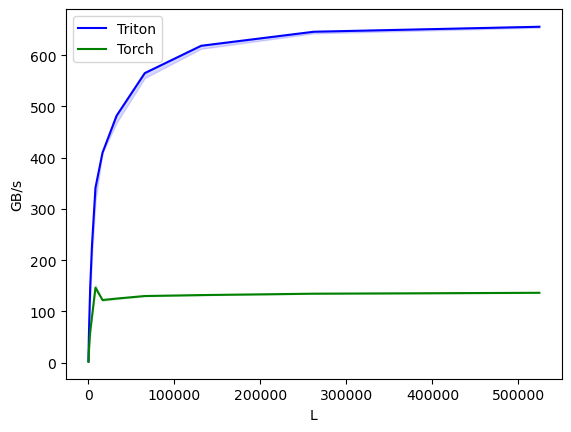

a:
           L      Triton       Torch
0       32.0    3.200000    1.454545
1       64.0    8.000000    2.909091
2      128.0   16.000000    5.818182
3      256.0   25.600001   11.636364
4      512.0   51.200001   21.333333
5     1024.0   85.333330   36.571428
6     2048.0  146.285712   60.235293
7     4096.0  227.555548   89.043476
8     8192.0  341.333321  146.285712
9    16384.0  409.600010  122.240141
10   32768.0  481.882344  125.068709
11   65536.0  564.965503  130.031747
12  131072.0  618.264154  131.863179
13  262144.0  645.674867  134.570839
14  524288.0  655.360017  136.320335


In [20]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["L"],
        x_vals=[16 * 2**i for i in range(1, 16)],
        x_log=False,
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="GB/s",
        plot_name="a",
        args={"B": 2, "C": 64, "p": 2.0},
    )
)
def benchmark(B, C, L, p, provider):
    x = th.rand(B, C, L, device="cuda")

    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: gem_torch_1d(x, p, keepdim=False),
            quantiles=quantiles,
        )
    elif provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: gem_ops1d(x, p, keepdim=False),
            quantiles=quantiles,
        )

    gbps = lambda ms: (x.nelement() * x.element_size()) * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)